Suppressing any unwanted warnings that may come up

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Setting up path for the config file

In [43]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'src'))

from config import DATA_DIR

Necessary imports

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Reading the dataset using the variable df and printing various basic info of the dataset

In [45]:
df=pd.read_csv(DATA_DIR/'diabetes_prediction_dataset.csv')
print(df.head().to_string(index=False))
print(df.tail().to_string(index=False))

gender  age  hypertension  heart_disease smoking_history   bmi  HbA1c_level  blood_glucose_level  diabetes
Female 80.0             0              1           never 25.19          6.6                  140         0
Female 54.0             0              0         No Info 27.32          6.6                   80         0
  Male 28.0             0              0           never 27.32          5.7                  158         0
Female 36.0             0              0         current 23.45          5.0                  155         0
  Male 76.0             1              1         current 20.14          4.8                  155         0
gender  age  hypertension  heart_disease smoking_history   bmi  HbA1c_level  blood_glucose_level  diabetes
Female 80.0             0              0         No Info 27.32          6.2                   90         0
Female  2.0             0              0         No Info 17.37          6.5                  100         0
  Male 66.0             0            

In [46]:
print(df.describe().to_string())

                 age  hypertension  heart_disease            bmi    HbA1c_level  blood_glucose_level       diabetes
count  100000.000000  100000.00000  100000.000000  100000.000000  100000.000000        100000.000000  100000.000000
mean       41.885856       0.07485       0.039420      27.320767       5.527507           138.058060       0.085000
std        22.516840       0.26315       0.194593       6.636783       1.070672            40.708136       0.278883
min         0.080000       0.00000       0.000000      10.010000       3.500000            80.000000       0.000000
25%        24.000000       0.00000       0.000000      23.630000       4.800000           100.000000       0.000000
50%        43.000000       0.00000       0.000000      27.320000       5.800000           140.000000       0.000000
75%        60.000000       0.00000       0.000000      29.580000       6.200000           159.000000       0.000000
max        80.000000       1.00000       1.000000      95.690000       9

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


Checking the class distribution of categoric columns

In [48]:
print(df['gender'].value_counts())

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64


Dropping the 'Other' value from 'gender' column because of the very few count

In [49]:
df = df[df['gender'] != 'Other'].reset_index(drop=True)

In [50]:
print(df['smoking_history'].value_counts())

smoking_history
No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: count, dtype: int64


In [51]:
print(df['diabetes'].value_counts())

diabetes
0    91482
1     8500
Name: count, dtype: int64


Here we can see a common issue seen in Machine Learning datasets, tareget class imbalance. The count of data present of the patients with diabetes is below 9%, so if we train our model without any modifications, it will make the model overfit and also bring down the recall (properly detecting diabetes). This approach for solution is discussed in the ML part.

Checking for null values

In [52]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Checking for any duplicated rows and dropping them

In [53]:
df.duplicated().sum()  
df.drop_duplicates(inplace=True) 

Plotting the outliers for numeric columns

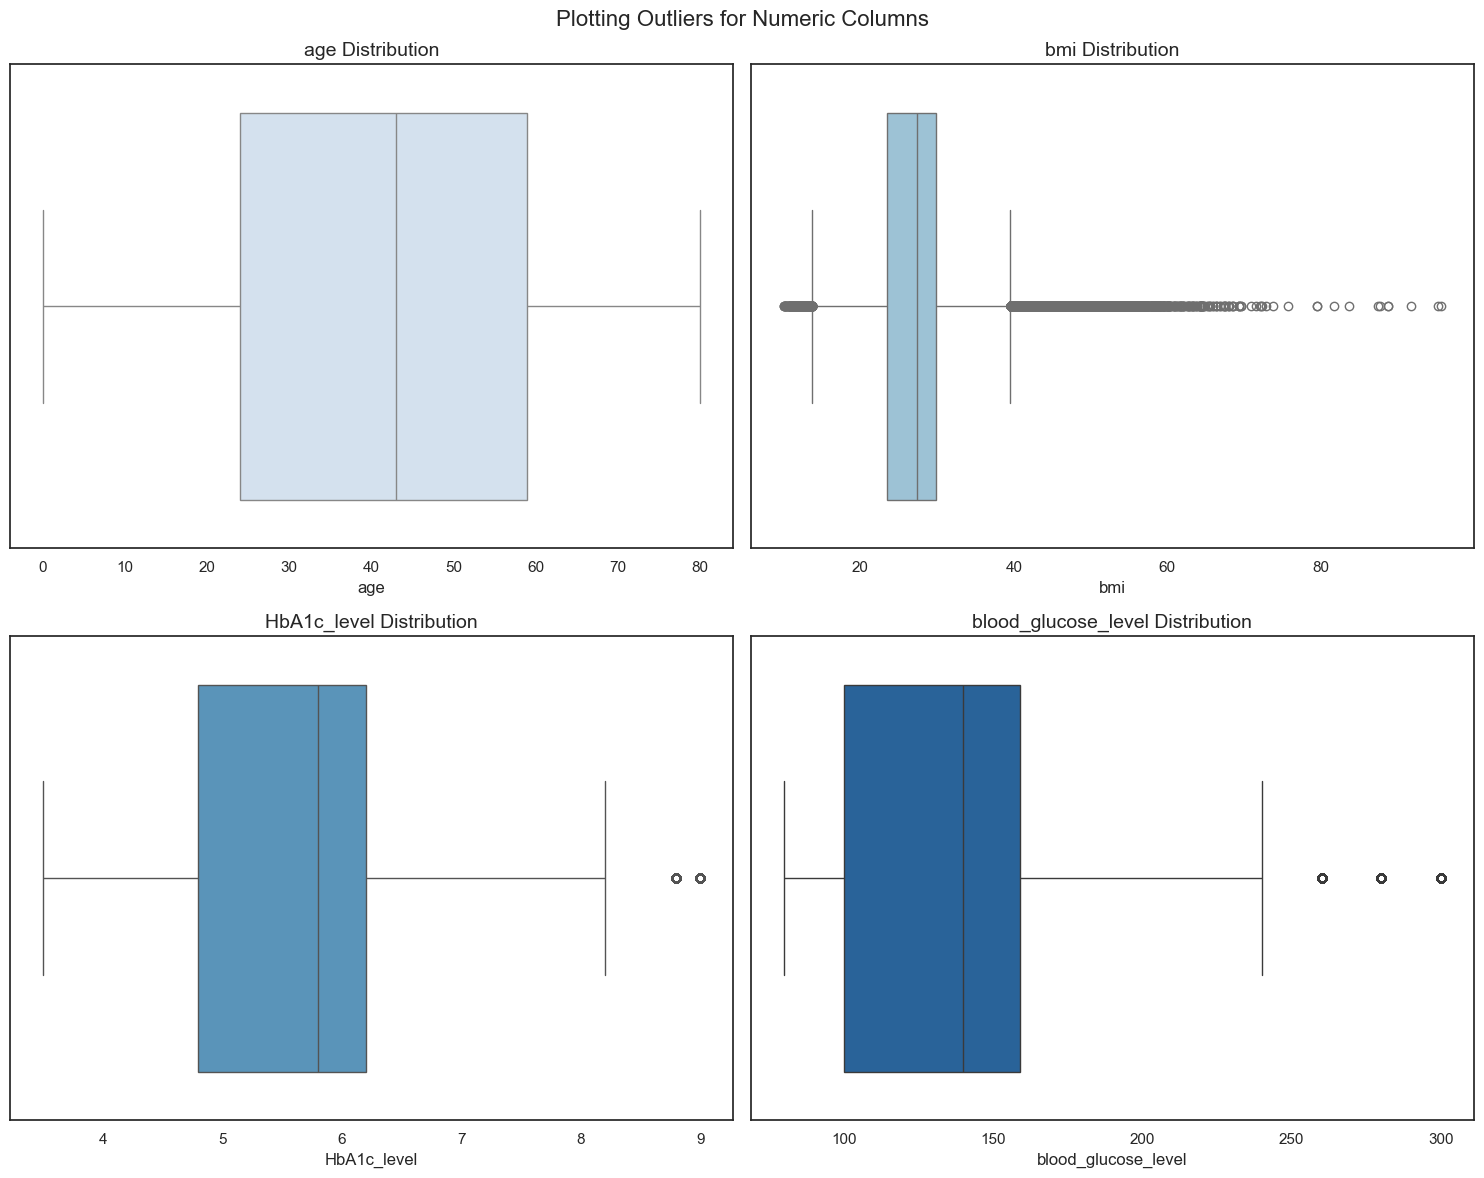

In [54]:
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

colors = sns.color_palette("Blues", n_colors=len(numeric_cols))  
plt.figure(figsize=(15, 12))
for count, i in enumerate(numeric_cols):
    plt.subplot(2, 2, count+1)
    sns.boxplot(data=df, x=i, color=colors[count])  
    plt.title(f'{i} Distribution', fontsize=14)  

plt.suptitle("Plotting Outliers for Numeric Columns", fontsize=16)
plt.tight_layout()
plt.show()


Dropping the outliers by retrieving the extreme values of the whiskers of the boxplots for better efficiency

In [55]:
def get_whisker_bounds(df, column):
    fig, ax = plt.subplots()
    box = ax.boxplot(df[column].dropna(), vert=False)
    plt.close(fig)

    whiskers = [line.get_xdata()[1] for line in box['whiskers']]
    return whiskers[0], whiskers[1]

def remove_outliers_using_whiskers(df):
    df_clean = df.copy()
    outliers = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        if col in ['bmi', 'blood_glucose_level', 'HbA1c_level']: 
            
            # MODIFY THIS IF STATEMENT FOR EACH DIFFERENT DATASETS!

            lower_whisker, upper_whisker = get_whisker_bounds(df, col)
            outlier_count = ((df[col] < lower_whisker) | (df[col] > upper_whisker)).sum()
            outliers[col] = (lower_whisker, upper_whisker, outlier_count)

            df_clean = df_clean[(df_clean[col] >= lower_whisker) & (df_clean[col] <= upper_whisker)]

    outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Lower Whisker', 'Upper Whisker', 'No. of Outliers'])

    print(outliers_df.to_string(index=True))
    return df_clean

df_cleaned = remove_outliers_using_whiskers(df)
print(f"\nOriginal shape: {df.shape}, New shape: {df_cleaned.shape}")

                     Lower Whisker  Upper Whisker  No. of Outliers
bmi                          13.71          39.55             5354
HbA1c_level                   3.50           8.20             1312
blood_glucose_level          80.00         240.00             2031

Original shape: (96128, 9), New shape: (88177, 9)


Plotting after removing outliers

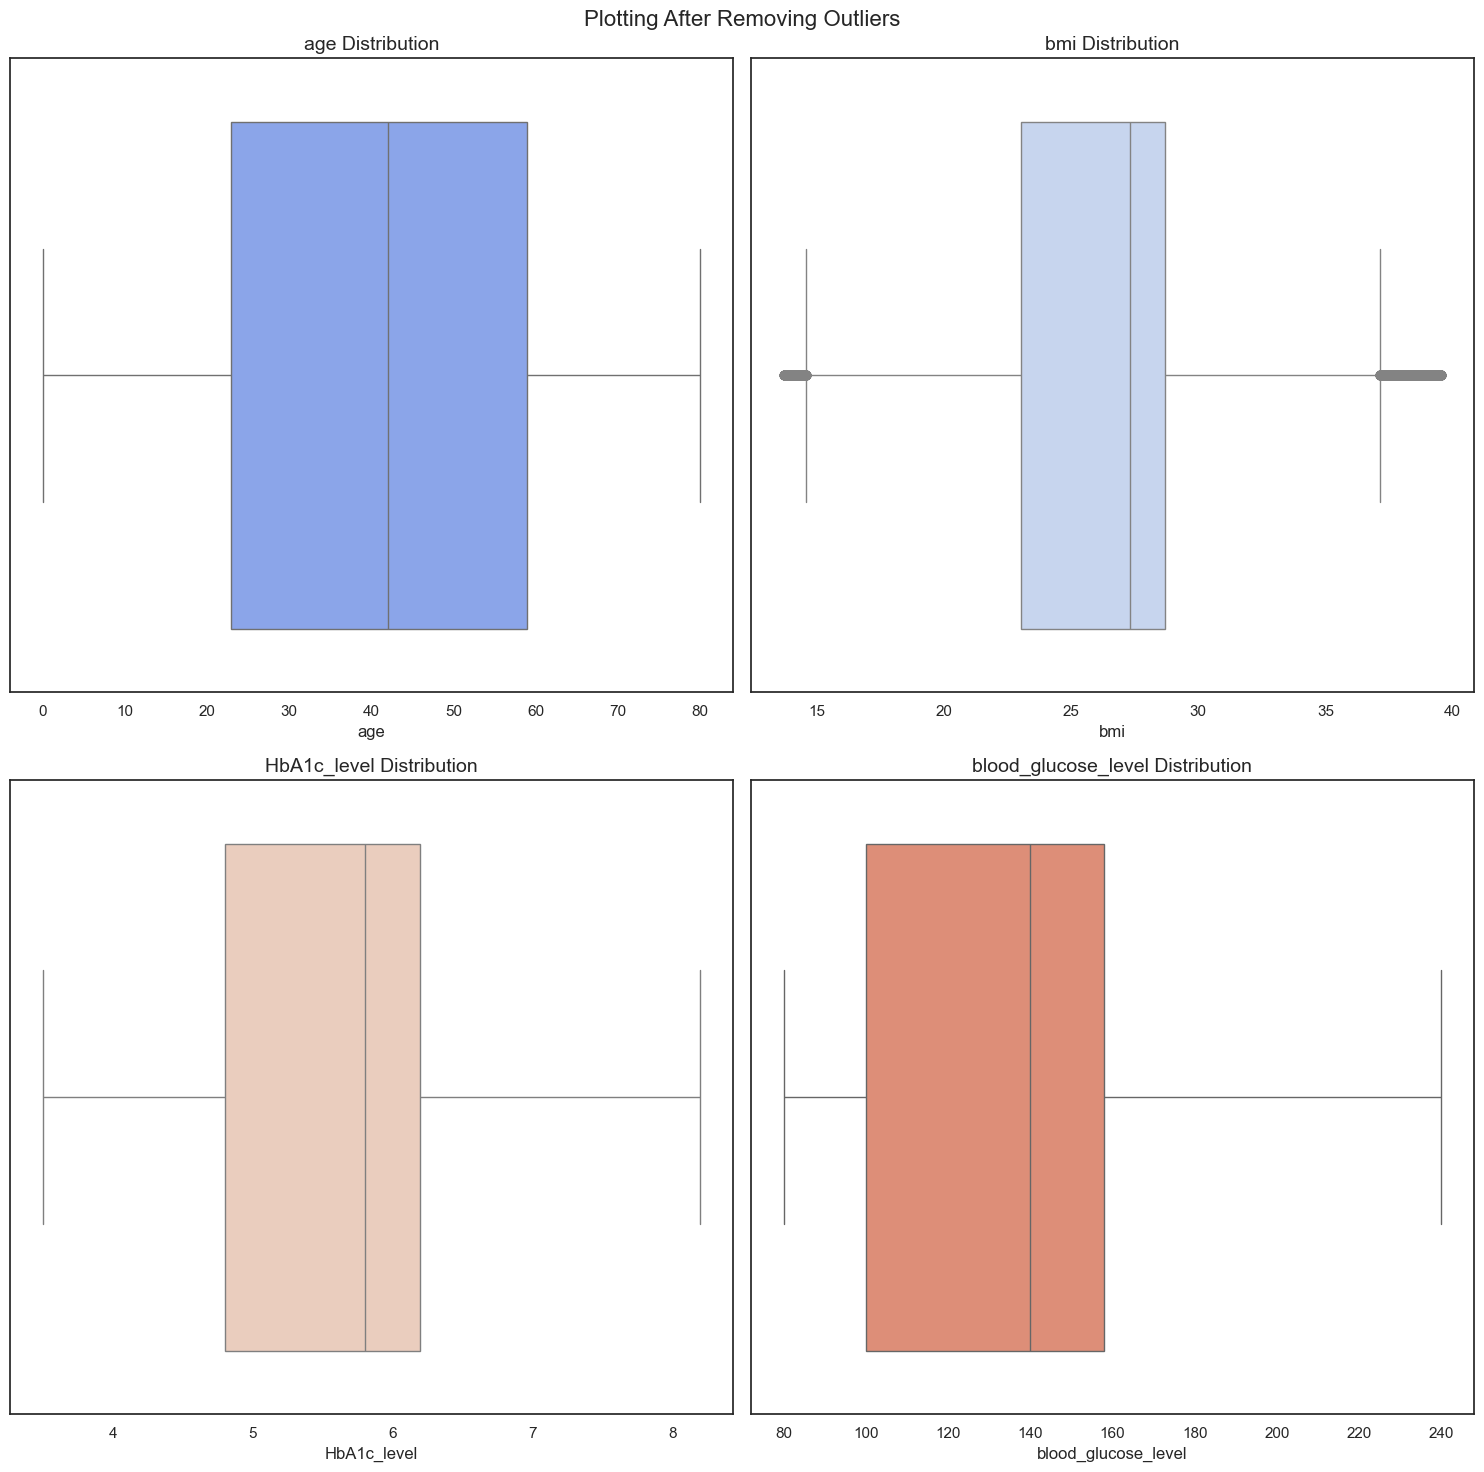

In [56]:
colors = sns.color_palette("coolwarm", n_colors=len(numeric_cols))  
plt.figure(figsize=(15, 15))
for count, col in enumerate(numeric_cols):
    plt.subplot(2, 2, count+1)
    sns.boxplot(data=df_cleaned, x=col, color=colors[count])  
    plt.title(f'{col} Distribution', fontsize=14)  

plt.suptitle("Plotting After Removing Outliers", fontsize=16)
plt.tight_layout()
plt.show()

In [57]:
df=df_cleaned

Now we do some basic EDA for a proper understanding how the data is distributed

#### Univariate EDA

1. Histogram plots for the numeric columns

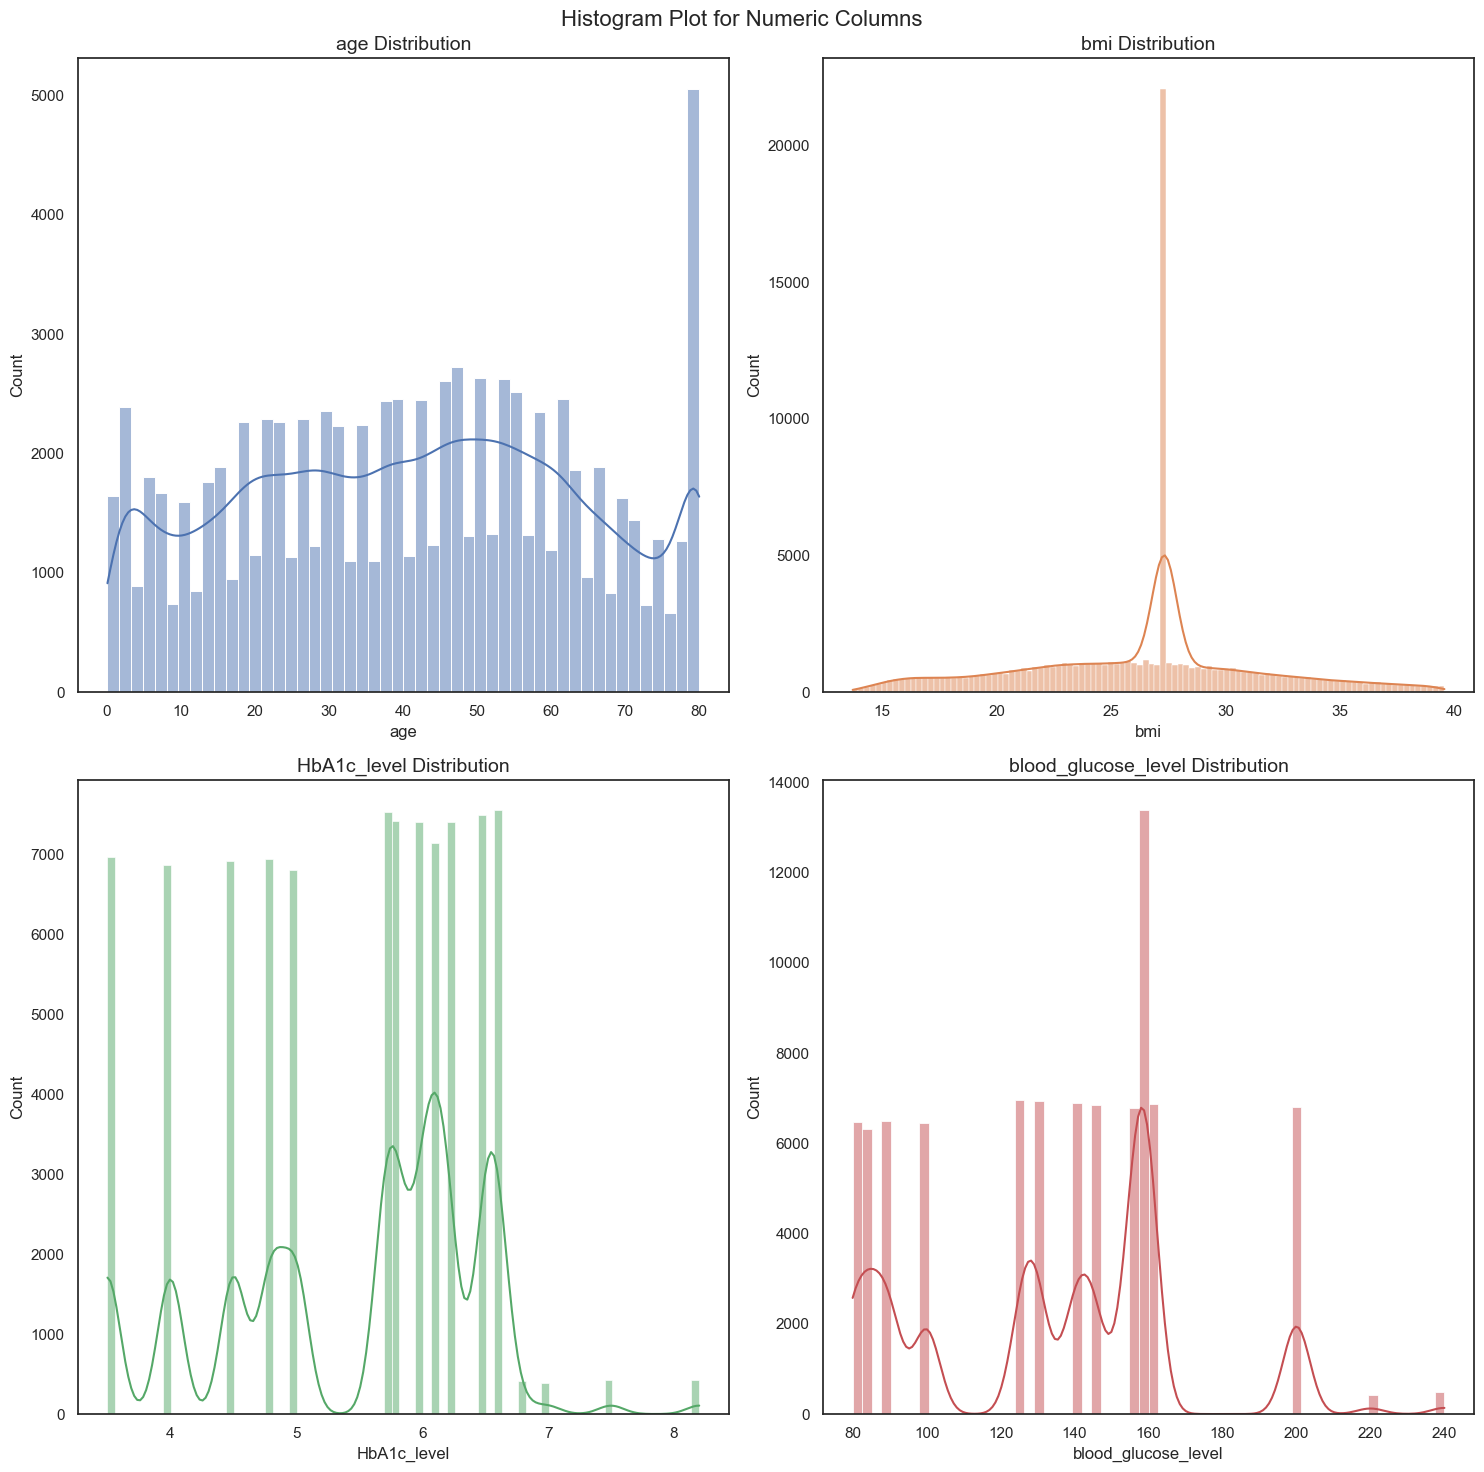

In [59]:
colors = sns.color_palette("deep", n_colors=len(numeric_cols))  
plt.figure(figsize=(15, 15))
for count, col in enumerate(numeric_cols):
    plt.subplot(2, 2, count + 1)
    sns.histplot(data=df, x=col, kde=True, color=colors[count])  
    plt.title(f'{col} Distribution', fontsize=14)  

plt.suptitle("Histogram Plot for Numeric Columns", fontsize=16)
plt.tight_layout()
plt.show()

From these graphs we can get an understanding, how the data lies throughout, and this also explains why new outliers came up when outliers were removed once in BMI. Because of the high count of BMI in the central area, clipping more and more will result in relative newer outliers. So it's better to leave them as it is. Besides, some of the new algorithms handles outliers better.

2. Bar charts for categoric columns <i>(We are considering the columns hypertension and heart_disease as categoric because they have only 2 values 0 and 1)</I>

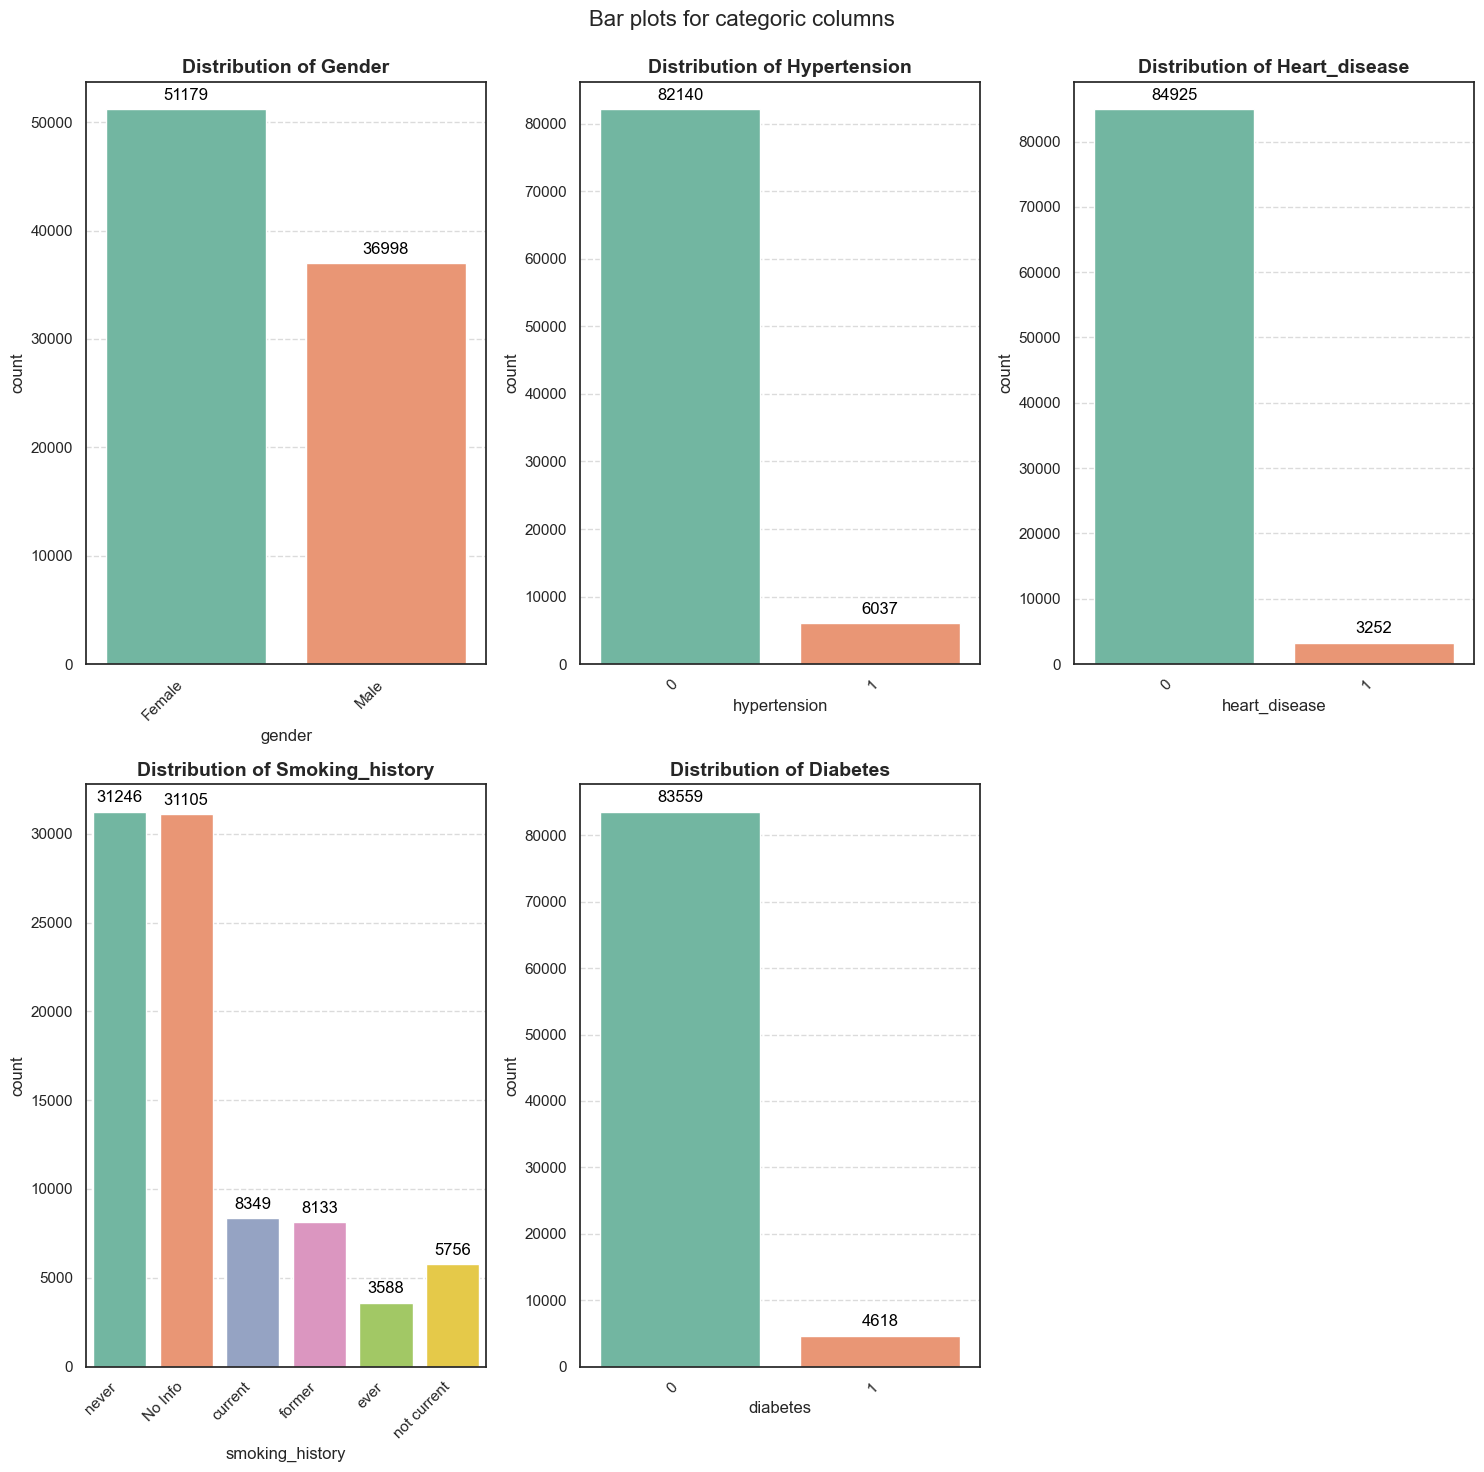

In [60]:
categoric_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history','diabetes']
plt.figure(figsize=(15, 15))

for count, i in enumerate(categoric_cols):
    plt.subplot(2, 3, count + 1)
    ax = sns.countplot(x=i, data=df, palette="Set2")  
    plt.title(f'Distribution of {i.capitalize()}', fontsize=14, weight='bold')
    plt.xticks(rotation=45, ha='right')  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  

    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=12, color='black', 
                    xytext=(0, 10),
                    textcoords='offset points')
plt.suptitle('Bar plots for categoric columns\n', fontsize=16)
plt.tight_layout()
plt.show()

The bar charts also reveals high imbalance in categoric columns. 

#### Bivariate EDA

3. Correlation Matrix Heatmap

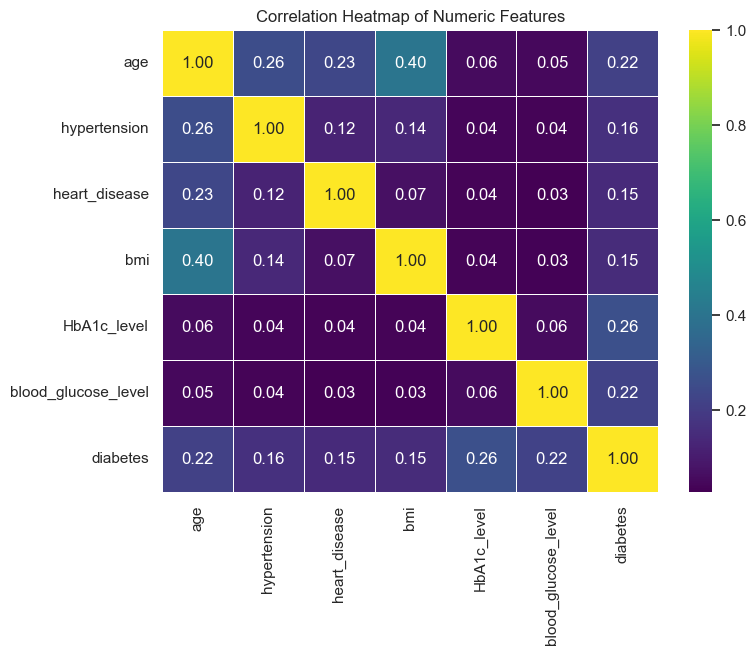

In [61]:
cols=df.select_dtypes(include=np.number)[:-1]
cor_matrix=cols.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap of Numeric Features")
plt.show()

The correlation matrix shows very small correlation between every columns. So all columns are good/ have some information for the model, and hence we do not remove the columns.

4. Violinplots of numeric columns vs target column

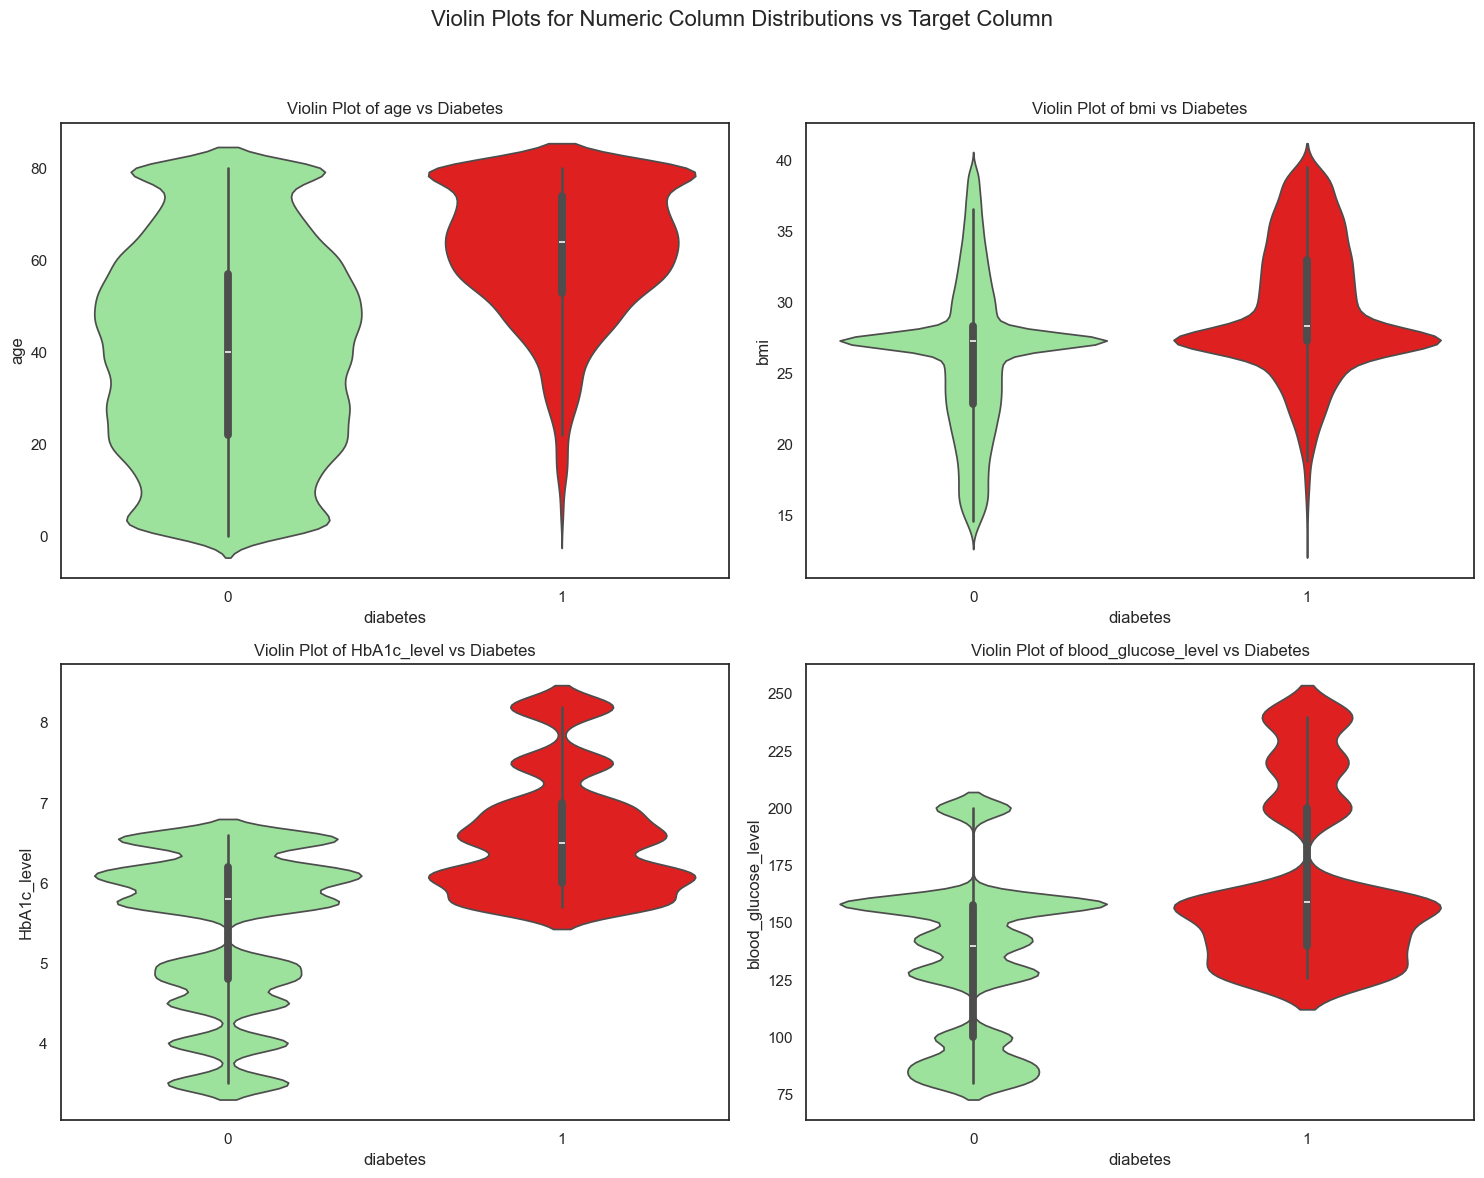

In [62]:
custom_palette = {'0': 'lightgreen', '1': 'red'}

plt.figure(figsize=(15, 12))
for count, col in enumerate(numeric_cols):
    plt.subplot(2, 2, count + 1)  
    sns.violinplot(x='diabetes', y=col, data=df, palette=custom_palette)
    plt.title(f'Violin Plot of {col} vs Diabetes')

plt.suptitle("Violin Plots for Numeric Column Distributions vs Target Column", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


So with this plot we can get a more better understanding of how the distribution of numeric columns are w.r.t the target column. For eg, in HbA1c vs Diabetes (3rd plot), we can see that for diabetes=0 (non diabetic patients) the HbA1c level is distributed from 3.5 to below 7 and for diabetes=1 (diabetic patients) the HbA1c level is distributed from 5.5 to 9+. And the width of the graph denotes the count of each y axis value.

#### Multivariate EDA

5. KDE Contour plots of HbA1c v/s blood-glucose level

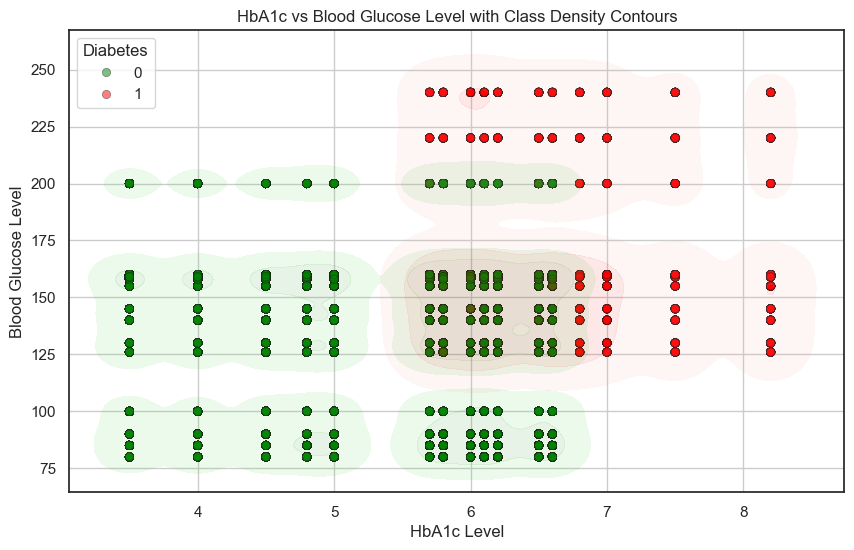

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='HbA1c_level',
    y='blood_glucose_level',
    hue='diabetes',
    palette={0: 'green', 1: 'red'},
    alpha=0.5,
    edgecolor='k'
)

for label, color in zip([0, 1], ['green', 'red']):
    subset = df[df['diabetes'] == label]
    sns.kdeplot(
        x=subset['HbA1c_level'],
        y=subset['blood_glucose_level'],
        levels=3,
        color=color,
        linewidths=1.5,
        fill=True,
        alpha=0.1,
        label=f'Density (diabetes={label})'
    )
    
plt.title("HbA1c vs Blood Glucose Level with Class Density Contours")
plt.xlabel("HbA1c Level")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Diabetes")
plt.grid(True)
plt.show()

So in this plot, we have HbA1c level on the x axis and Blood Glucose Level on the y axis. And each data points are visualized with these coordinates. And the color of each data points are determined by their target column value (diabetes 0 for red and 1 for green). And as expected, on the lower left corner i.e low blood glucose level and low HbA1c levels, we can see most non diabetic patients and as the graph moves away, the change is observed as expected.

---

So, from these insights, we begin machine learning.

In [65]:
print(df.head(2).to_string(index=False))

gender  age  hypertension  heart_disease smoking_history   bmi  HbA1c_level  blood_glucose_level  diabetes
Female 80.0             0              1           never 25.19          6.6                  140         0
Female 54.0             0              0         No Info 27.32          6.6                   80         0


Necessary imports

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

Splitting the feature and target variables. Also defining the numeric, categoric and binary features

In [67]:
X = df.drop('diabetes', axis=1)
y = df['diabetes'] 

numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'smoking_history']  
binary_features = ['hypertension', 'heart_disease'] 

In [68]:
print(X.head(3).to_string(index=False))
print(y.head(3).to_string(index=False))

gender  age  hypertension  heart_disease smoking_history   bmi  HbA1c_level  blood_glucose_level
Female 80.0             0              1           never 25.19          6.6                  140
Female 54.0             0              0         No Info 27.32          6.6                   80
  Male 28.0             0              0           never 27.32          5.7                  158
0
0
0


Defining the preprocessor structure

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

Splitting the data into training and testing data. Since we use cross-validation while hp-tuning, validation split is not done

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Defining the model and the base pipeline structure, fitting and making prediction to get model statistics

In [71]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

Printing the classification report

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16712
           1       0.81      0.56      0.66       924

    accuracy                           0.97     17636
   macro avg       0.89      0.77      0.82     17636
weighted avg       0.97      0.97      0.97     17636



As expected, due to the class imbalance, the model is overfitted towards class 0 (non diabetic) and has overall high accuracy. But the recall of the minority class (1) shows the underlying issue of the current model. Recall of 56% means that the model successfully predicted 56 instances of class 1 out of 100, which also means the model mispredicted 44 instances of class 1. In simpler terms, currently the model predicts 44 out of 100 people who are diabetic as non-diabetic. This is bad. So we have to implement some class imbalance fix-up mechanisms.

AUC-ROC curve

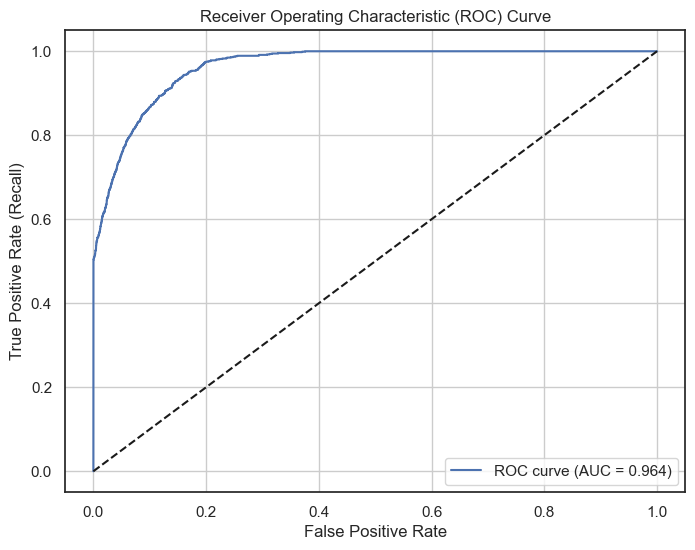

In [73]:
y_probs = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Confusion Matrix

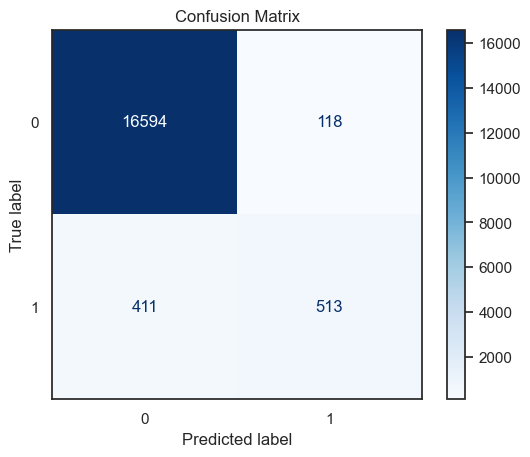

In [74]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The confusion matrix also points to the model overfitting. The confusion matrix stats are:
<ul>
<li>Out of 16712 instances of true 0 (non diabetics), 16594 were predicted as 0 (non diabetic) and 118 were predicted as 1 (diabetic). (99% accuracy)
<li>Out of 924 instances of true 1 (diabetic), 411 were predicted as 0 (non diabetic) and 513 were predicted as 1(diabetic). (56% accuracy)
</ul>

Overall this is a serious downside of the model

Hyperparameter tuning the model using Randomized Search CV

In [75]:
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.9, 1.0],
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__gamma': [0, 1, 3]
}

search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_iter=10, random_state=42)
search.fit(X_train, y_train)
print(search.best_params_)

{'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 1, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 1, 'classifier__colsample_bytree': 0.7}


Fitting the model with the best hyperparamters and also SMOTE is applied to handle class imbalance (as much as possible)

In [76]:
best_params = search.best_params_
clean_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
best_model = XGBClassifier(**clean_params, use_label_encoder=False, eval_metric='logloss',enable_categorical=False, random_state=42)

final_pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_model)
])

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

Generating the new classification report

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16712
           1       0.69      0.62      0.65       924

    accuracy                           0.97     17636
   macro avg       0.83      0.80      0.82     17636
weighted avg       0.96      0.97      0.96     17636



As we can seem, the stats have improved

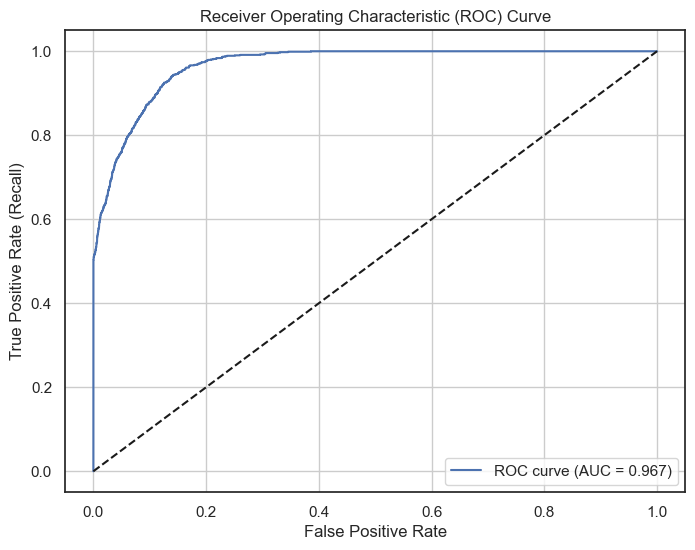

In [78]:
y_probs = final_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

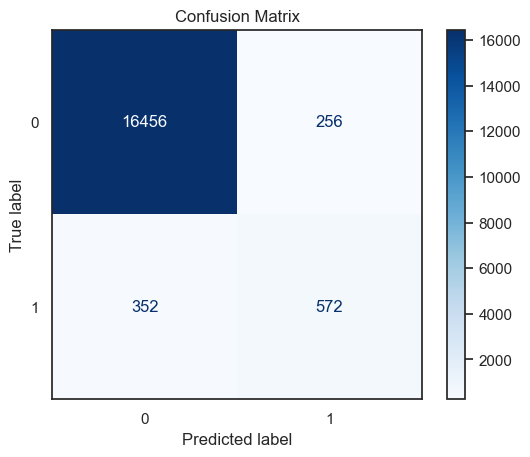

In [79]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Testing a custom input

In [80]:
x_custom = [['Female', 23, 0, 1, 'current', 27, 5, 50]]
columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
x_custom_df = pd.DataFrame(x_custom, columns=columns)

y_custom = final_pipeline.predict(x_custom_df)
print(y_custom)

[0]


Now we modify the pipeline before saving it, because SMOTE is only needed at the training stage, and isn't required for deployment

In [ ]:
from sklearn.pipeline import Pipeline  

inference_pipeline = Pipeline([
    ('preprocessing', final_pipeline.named_steps['preprocessing']),
    ('classifier', final_pipeline.named_steps['classifier'])
])

Saving the final pipeline for deployment

In [82]:
import joblib
from config import MODELS_DIR

joblib.dump(inference_pipeline, MODELS_DIR/'final_pipeline.pkl')
print("Pipeline saved successfully!")

Pipeline saved successfully!


---